In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdmetrics.reports.single_table import QualityReport
from sdmetrics.visualization import get_column_plot,set_plotly_config
#import mlflow
from sdmetrics.single_table import BinaryAdaBoostClassifier, CategoricalCAP, CategoricalEnsemble, NumericalSVR
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder



In [5]:
# mlflow.set_tracking_uri("sqlite:///mlflow.db")
# mlflow.set_experiment("admissions")


In [6]:
admissions_df = pd.read_csv('Dataset/bar_pass_prediction.csv')
print(admissions_df.shape)
print(admissions_df.columns)
print(admissions_df.isnull().sum())
display(admissions_df.head())

(22407, 39)
Index(['decile1b', 'decile3', 'ID', 'decile1', 'sex', 'race', 'cluster',
       'lsat', 'ugpa', 'zfygpa', 'DOB_yr', 'grad', 'zgpa', 'bar1', 'bar1_yr',
       'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'parttime',
       'male', 'race1', 'race2', 'Dropout', 'other', 'asian', 'black', 'hisp',
       'pass_bar', 'bar', 'bar_passed', 'tier', 'index6040', 'indxgrp',
       'indxgrp2', 'dnn_bar_pass_prediction', 'gpa'],
      dtype='object')
decile1b                   1604
decile3                    1604
ID                            0
decile1                    1092
sex                           5
race                         16
cluster                      96
lsat                          0
ugpa                          0
zfygpa                      984
DOB_yr                       50
grad                          3
zgpa                       1289
bar1                          0
bar1_yr                      39
bar2                          0
bar2_yr             

,decile1b,decile3,ID,decile1,sex,race,cluster,lsat,ugpa,zfygpa,...,hisp,pass_bar,bar,bar_passed,tier,index6040,indxgrp,indxgrp2,dnn_bar_pass_prediction,gpa
0,10.0,10.0,2,10.0,1.0,7.0,1.0,44.0,3.5,1.33,...,0,1,a Passed 1st time,True,4.0,886.842082,g 700+,i 820+,0.979804,3.5
1,5.0,4.0,3,5.0,1.0,7.0,2.0,29.0,3.5,-0.11,...,0,1,a Passed 1st time,True,2.0,649.999987,f 640-700,f 640-700,0.979804,3.5
2,3.0,2.0,36,3.0,2.0,7.0,3.0,36.0,3.5,-0.64,...,0,1,a Passed 1st time,True,3.0,760.526298,g 700+,h 760-820,0.979804,3.5
3,7.0,4.0,52,7.0,2.0,7.0,3.0,39.0,3.5,0.34,...,0,1,a Passed 1st time,True,3.0,807.894717,g 700+,h 760-820,0.979804,3.5
4,9.0,8.0,55,9.0,2.0,7.0,4.0,48.0,3.5,1.02,...,0,1,a Passed 1st time,True,5.0,949.999974,g 700+,i 820+,0.979804,3.5


In [7]:
admissions_sub = admissions_df[['ID','sex', 'race',
       'lsat', 'ugpa', 'DOB_yr', 'grad', 'bar1', 'bar1_yr',
       'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'Dropout',
       'bar_passed','gpa', 'index6040', 'indxgrp',
       'indxgrp2' ]]


In [8]:
# Remove all rows with missing values
admissions_sub_cleaned = admissions_sub.dropna()
print(admissions_sub_cleaned.shape)
print(admissions_sub_cleaned.isnull().sum())

(21985, 21)
ID            0
sex           0
race          0
lsat          0
ugpa          0
DOB_yr        0
grad          0
bar1          0
bar1_yr       0
bar2          0
bar2_yr       0
fulltime      0
fam_inc       0
age           0
gender        0
Dropout       0
bar_passed    0
gpa           0
index6040     0
indxgrp       0
indxgrp2      0
dtype: int64


In [9]:
# Select only the categorical columns
categorical_columns = admissions_sub_cleaned.select_dtypes(include=['object'])

# Loop through each categorical column and print value counts
for column in categorical_columns.columns:
    print(f"Value counts for column '{column}':")
    print(admissions_sub_cleaned[column].value_counts())
    print()

Value counts for column 'grad':
grad
Y    21897
X       87
O        1
Name: count, dtype: int64

Value counts for column 'bar1':
bar1
P    19491
F     2494
Name: count, dtype: int64

Value counts for column 'bar2':
bar2
P    20852
F     1133
Name: count, dtype: int64

Value counts for column 'gender':
gender
male      12323
female     9662
Name: count, dtype: int64

Value counts for column 'Dropout':
Dropout
NO     21984
YES        1
Name: count, dtype: int64

Value counts for column 'indxgrp':
indxgrp
g 700+         15013
f 640-700       3702
e 580-640       1903
d 520-580        811
c 460-520        396
b 400-460        125
a under 400       35
Name: count, dtype: int64

Value counts for column 'indxgrp2':
indxgrp2
i 820+         5141
g 700-760      5052
h 760-820      4820
f 640-700      3702
e 580-640      1903
d 520-580       811
c 460-520       396
b 400-460       125
a under 400      35
Name: count, dtype: int64


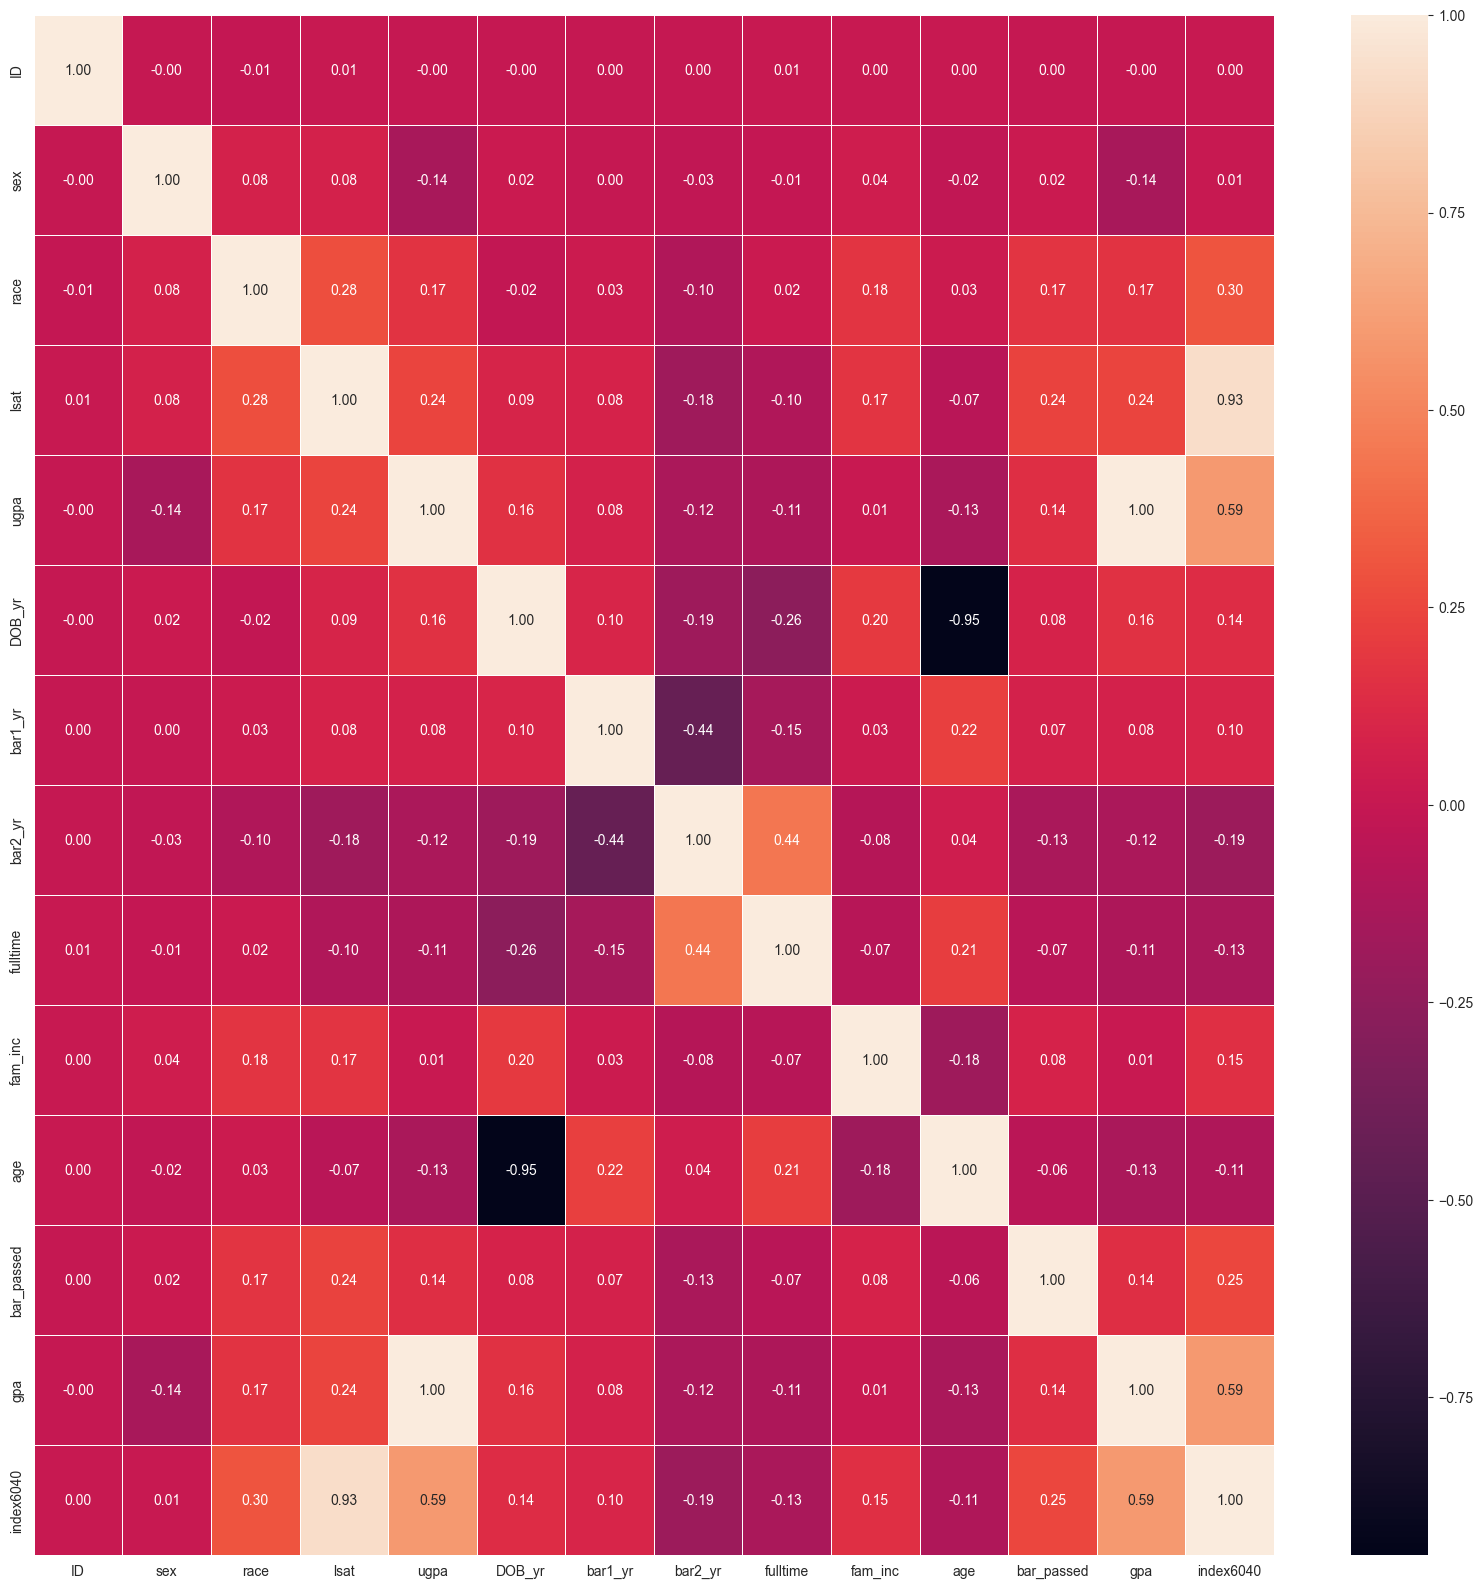

In [10]:
f,ax = plt.subplots(figsize=(20, 20))
sns.heatmap(admissions_sub_cleaned.corr(numeric_only=True), annot=True, linewidths=.5, fmt= '.2f',ax=ax)
plt.show()

In [11]:
admissions_sub_cleaned.dtypes

ID              int64
sex           float64
race          float64
lsat          float64
ugpa          float64
DOB_yr        float64
grad           object
bar1           object
bar1_yr       float64
bar2           object
bar2_yr       float64
fulltime      float64
fam_inc       float64
age           float64
gender         object
Dropout        object
bar_passed       bool
gpa           float64
index6040     float64
indxgrp        object
indxgrp2       object
dtype: object

In [12]:
# Define columns to change their data types to categorical
update_categorical_columns = ['sex', 'race', 'bar1_yr', 'bar2_yr', 'fulltime', 'fam_inc']

# Change data types of categorical columns
admissions_sub_cleaned[update_categorical_columns] = admissions_sub_cleaned[update_categorical_columns].astype('category')


In [13]:
admissions_sub_cleaned.dtypes

ID               int64
sex           category
race          category
lsat           float64
ugpa           float64
DOB_yr         float64
grad            object
bar1            object
bar1_yr       category
bar2            object
bar2_yr       category
fulltime      category
fam_inc       category
age            float64
gender          object
Dropout         object
bar_passed        bool
gpa            float64
index6040      float64
indxgrp         object
indxgrp2        object
dtype: object

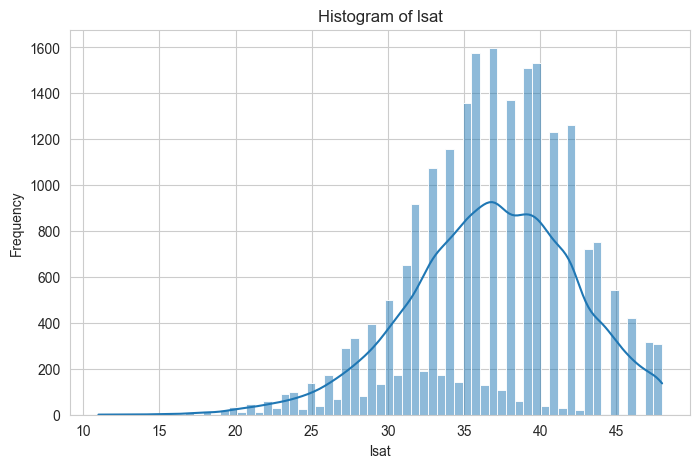

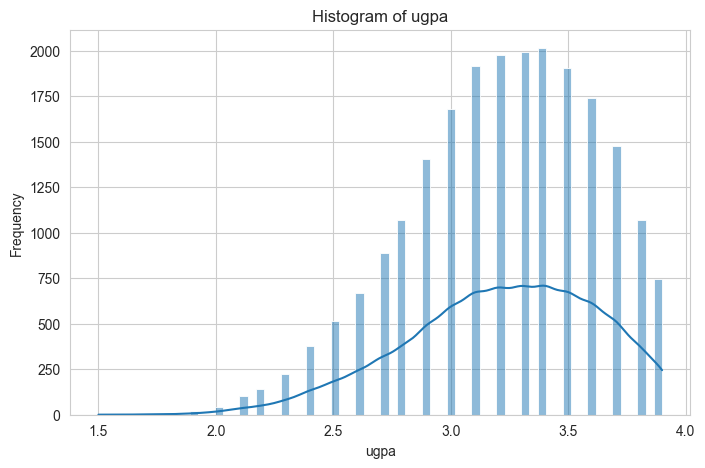

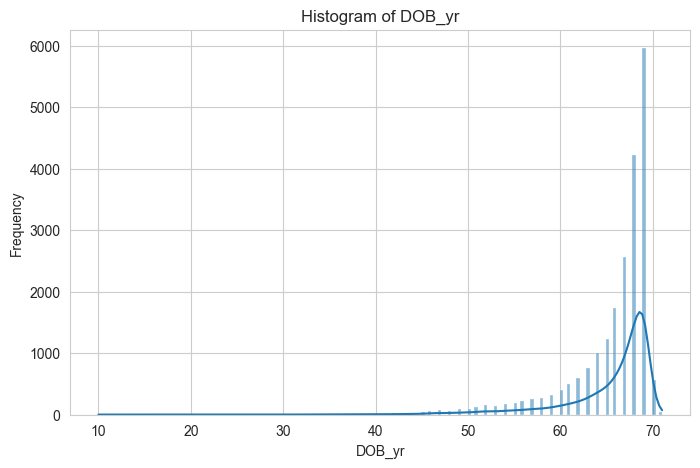

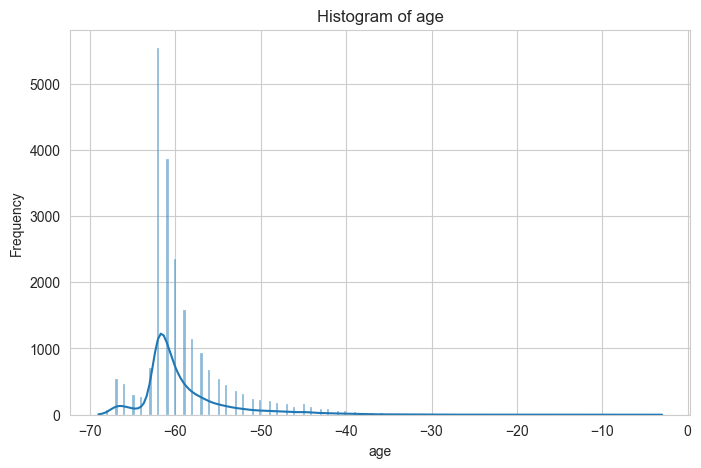

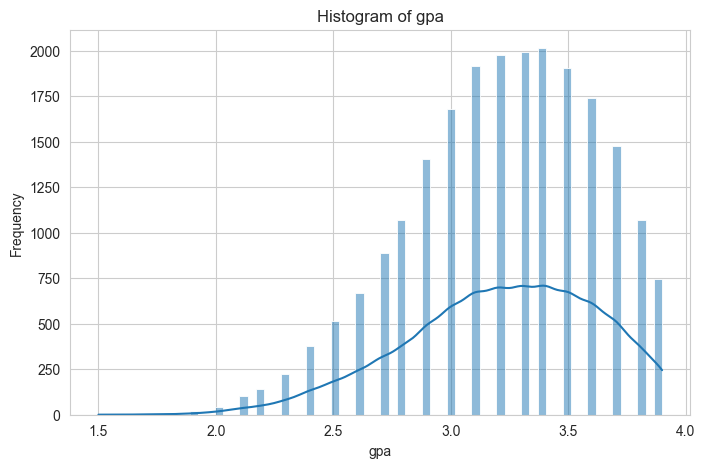

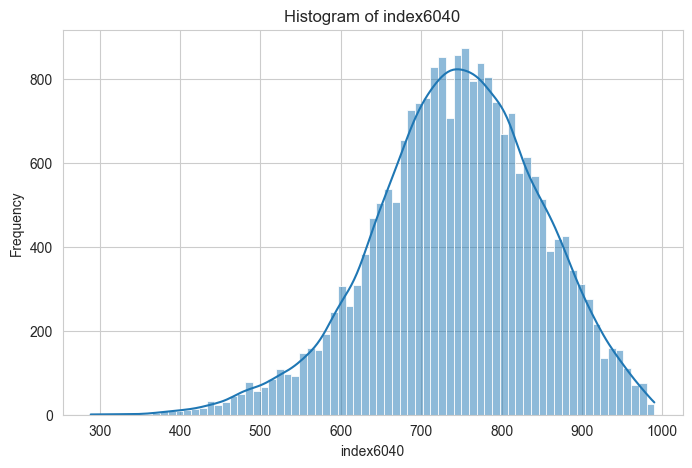

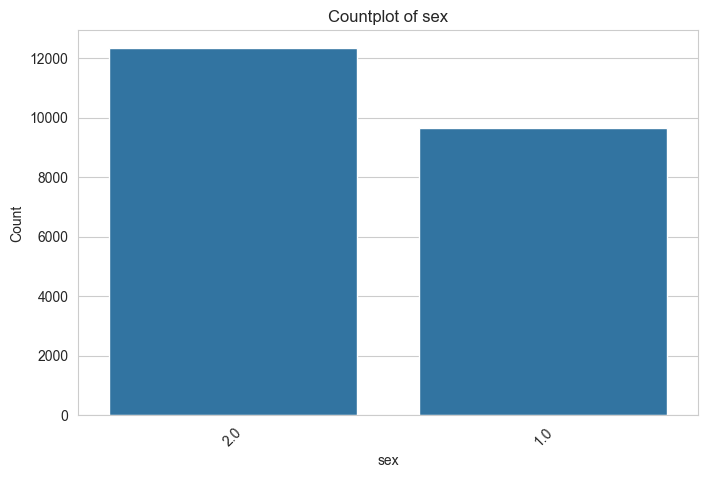

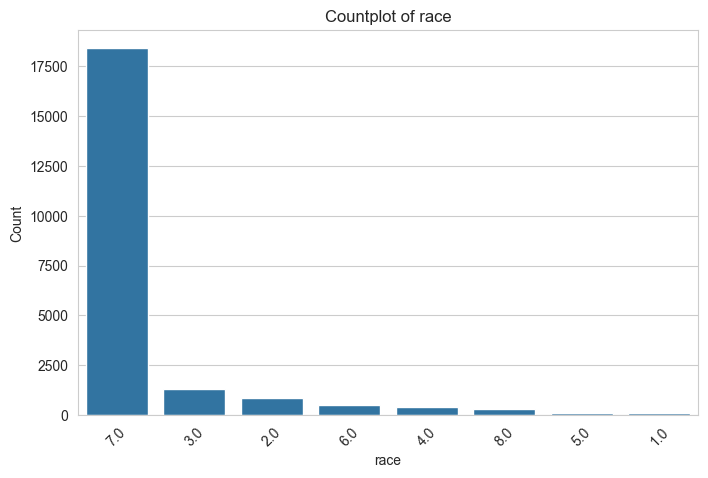

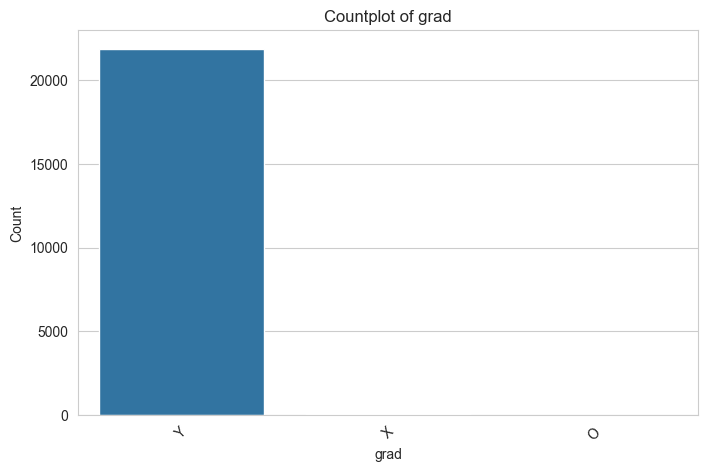

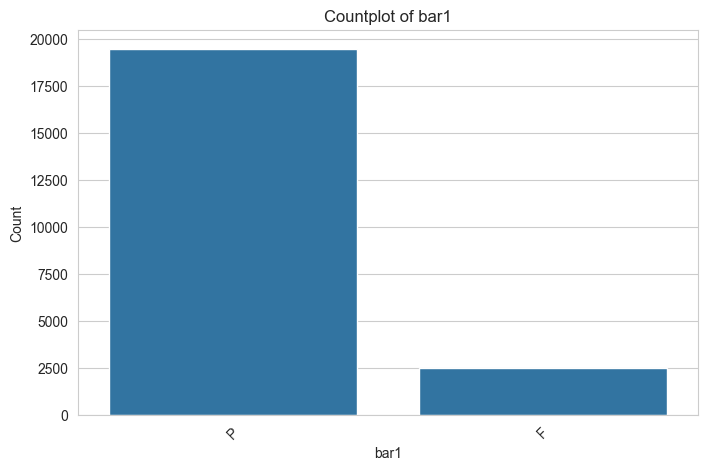

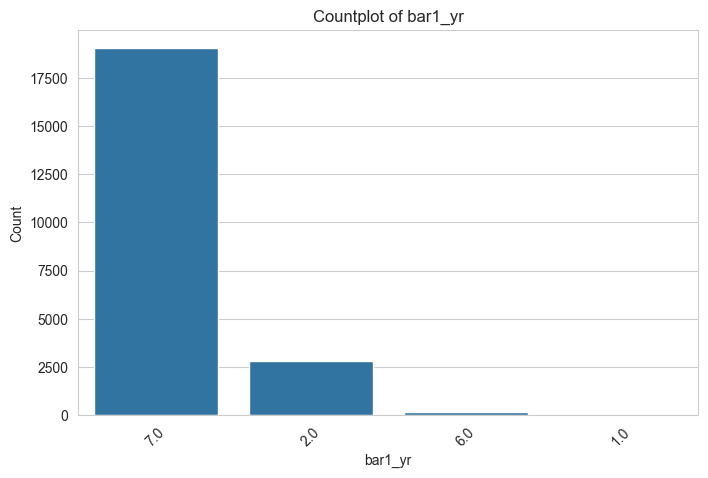

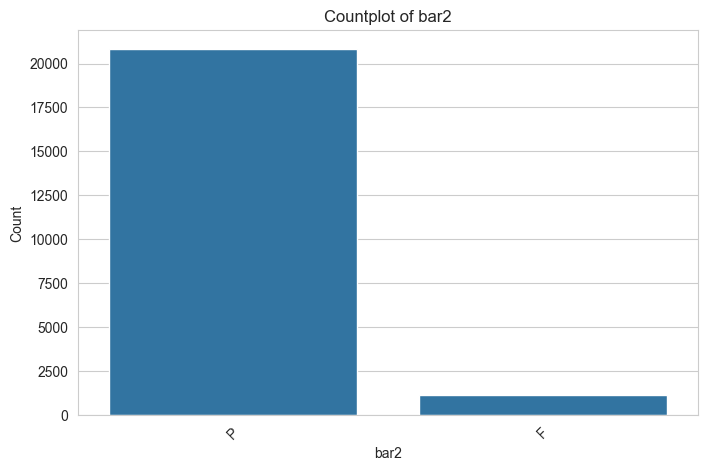

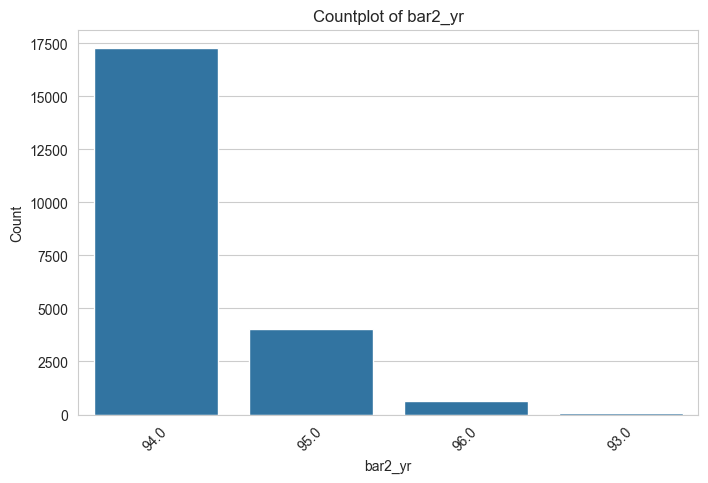

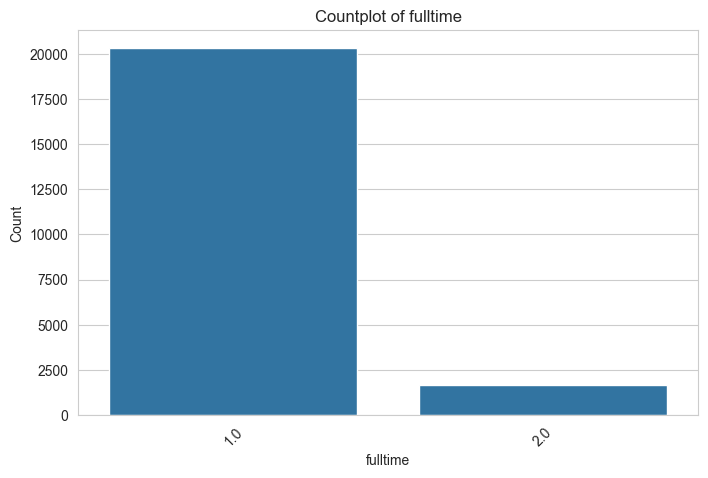

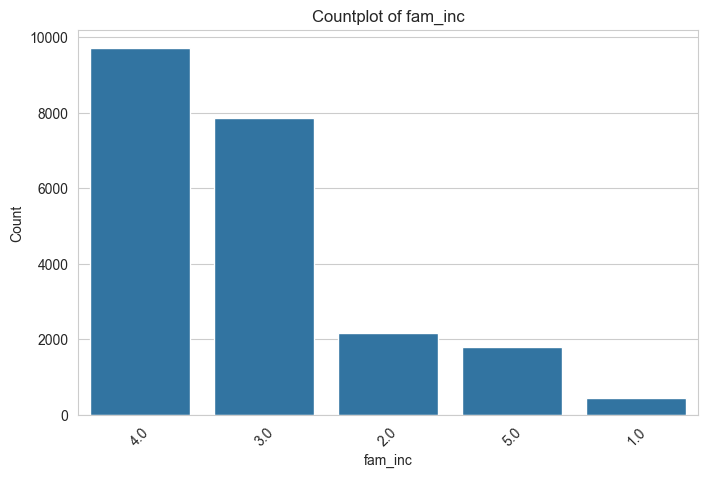

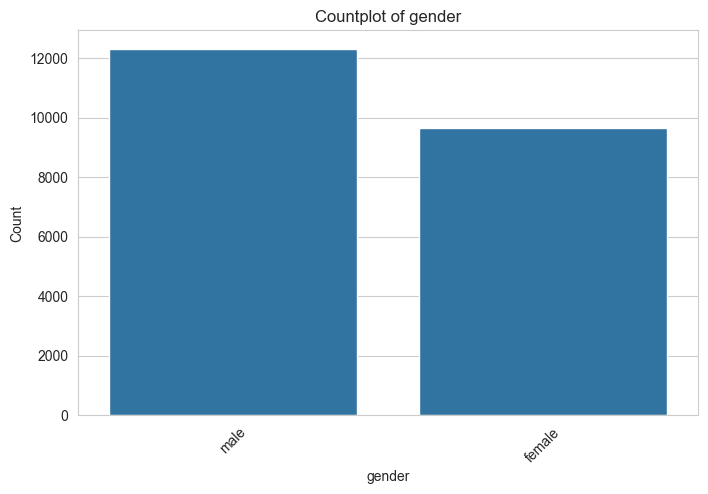

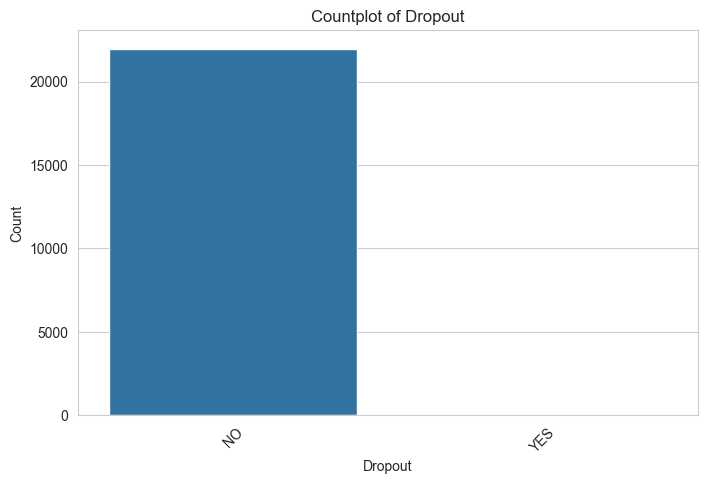

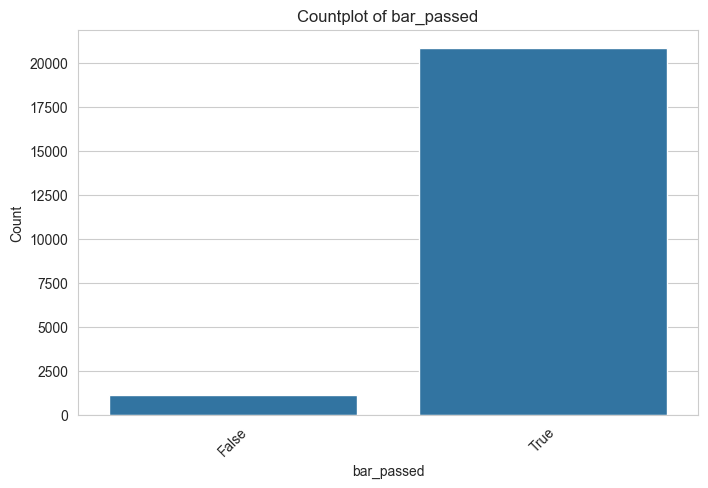

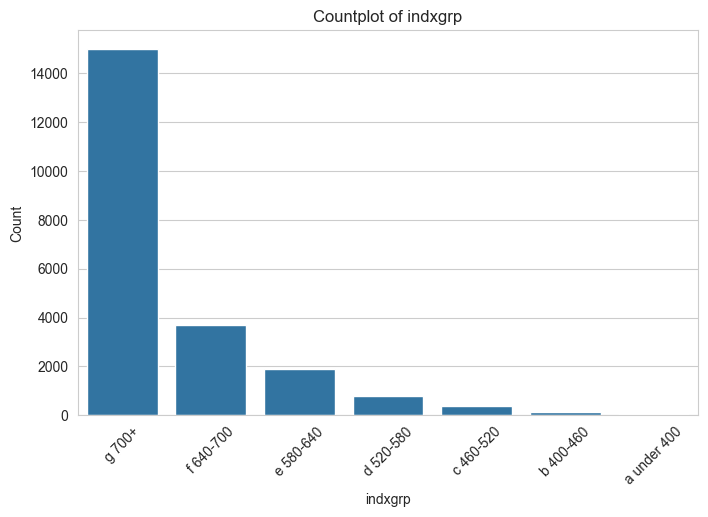

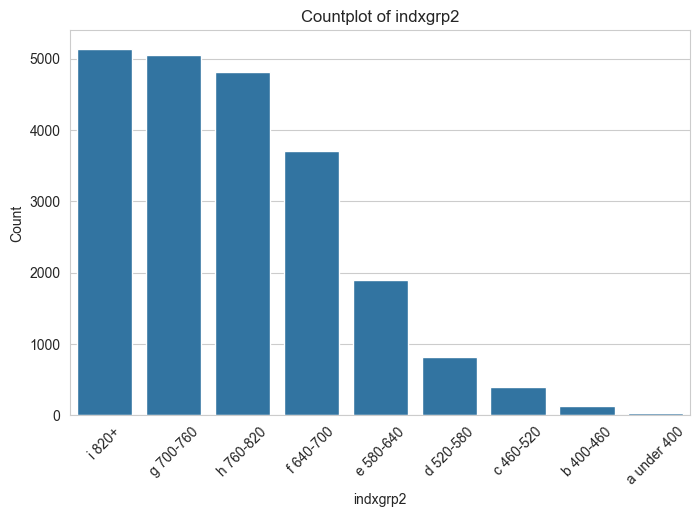

In [14]:
# Select numerical columns
numerical_columns = ['lsat', 'ugpa', 'DOB_yr', 'age', 'gpa', 'index6040']

# Select categorical or boolean columns
categorical_columns = ['sex', 'race', 'grad', 'bar1', 'bar1_yr', 'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'gender', 'Dropout', 'bar_passed', 'indxgrp', 'indxgrp2']

# Plot histograms for numerical columns
for column in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(admissions_sub_cleaned[column].dropna(), kde=True)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Plot countplots for categorical or boolean columns
for column in categorical_columns:
    plt.figure(figsize=(8, 5))
    if column == 'bar_passed':  # Special handling for boolean column
        sns.countplot(x=column, data=admissions_sub_cleaned)
    else:
        sns.countplot(x=column, data=admissions_sub_cleaned, order=admissions_sub_cleaned[column].value_counts().index)
    plt.title(f'Countplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

In [15]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(admissions_sub_cleaned)

In [18]:
print('Auto detected data:\n')
metadata.visualize()

Auto detected data:


B:\g.acheampong\Documents\SDG\sdg_env\Lib\site-packages\sdv\metadata\visualization.py:128: RuntimeWarning: Graphviz does not seem to be installed on this system. For full metadata visualization capabilities, please make sure to have its binaries propertly installed: https://graphviz.gitlab.io/download/
  warnings.warn(warning_message, RuntimeWarning)


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [19]:
metadata.validate()
#metadata.save_to_json('admissions_metadata.json')

# Gaussian Copula

## Produce the synthetic data using a gaussian copula

In [20]:
synthesizer = GaussianCopulaSynthesizer(metadata,  default_distribution="gaussian_kde")
synthesizer.fit(admissions_sub_cleaned)

B:\g.acheampong\Documents\SDG\sdg_env\Lib\site-packages\sdv\single_table\base.py:79: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


ContextualVersionConflict: (urllib3 2.2.1 (b:\g.acheampong\documents\sdg\sdg_env\lib\site-packages), Requirement.parse('urllib3<2.1,>=1.25.4; python_version >= "3.10"'), {'botocore'})

In [ ]:
synthetic_data_GC = synthesizer.sample(num_rows=2000)
synthetic_data_GC.head()

## Evaluate the produced synthetic data 

In [ ]:
diagnostic = run_diagnostic(
    real_data=admissions_sub_cleaned,
    synthetic_data=synthetic_data_GC,
    metadata=metadata
)

In [ ]:
quality_report = evaluate_quality(
    admissions_sub_cleaned,
    synthetic_data_GC,
    metadata
)

In [ ]:
quality_report.get_details('Column Shapes')

In [ ]:
fig = get_column_plot(
    real_data=admissions_sub_cleaned,
    synthetic_data=synthetic_data_GC,
    column_name='bar_passed'
)

fig.show()

In [ ]:
fig = get_column_plot(
    real_data=admissions_sub_cleaned,
    synthetic_data=synthetic_data_GC,
    column_name='fam_inc',
    plot_type = 'distplot'
)

fig.show()

In [ ]:
fig = get_column_plot(
    real_data=admissions_sub_cleaned,
    synthetic_data=synthetic_data_GC,
    column_name='fulltime'
)

fig.show()

In [ ]:
# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot correlation heatmap for the real dataset
sns.heatmap(admissions_sub_cleaned.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt=".2f", ax=axes[0])
axes[0].set_title('Real Dataset Correlation Heatmap')

# Plot correlation heatmap for the synthetic dataset
sns.heatmap(synthetic_data_GC.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt=".2f", ax=axes[1])
axes[1].set_title('Synthetic Dataset Correlation Heatmap')

plt.tight_layout()
plt.show()

In [ ]:
BinaryAdaBoostClassifier.compute(admissions_sub_cleaned, synthetic_data_GC, target = 'bar_passed')

In [ ]:
score = CategoricalCAP.compute(
    real_data=admissions_sub_cleaned,
    synthetic_data=synthetic_data_GC,
    key_fields=['age', 'fam_inc'],
    sensitive_fields=['indxgrp']
)
score

# SMOTE

In [ ]:
admissions_sub_cleaned.columns = admissions_sub_cleaned.columns.astype(str)


# Detect categorical columns automatically
categorical_columns = admissions_sub_cleaned.select_dtypes(include=['object', 'category']).columns.tolist()



# Encode categorical columns using one-hot encoding
encoder = OneHotEncoder(drop='first', sparse=False)  # drop='first' to avoid multicollinearity
X_categorical_encoded = encoder.fit_transform(admissions_sub_cleaned[categorical_columns])
X_categorical_encoded_df = pd.DataFrame(X_categorical_encoded, columns=encoder.get_feature_names_out())

# Select numerical columns
numerical_columns = admissions_sub_cleaned.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Concatenate encoded categorical columns and numerical columns
X = pd.concat([admissions_sub_cleaned[numerical_columns].reset_index(), X_categorical_encoded_df.reset_index()], axis=1)
X.columns = X.columns.astype(str)

# Target variable
y = admissions_sub_cleaned['bar_passed']

# Apply SMOTE to generate synthetic data
smote = SMOTE(sampling_strategy = 'all')
X_synthetic, y_synthetic = smote.fit_resample(X, y)

# Concatenate synthetic features and target variable into a DataFrame
synthetic_data_SMOTE = pd.concat([pd.DataFrame(X_synthetic, columns=X.columns).reset_index(), pd.Series(y_synthetic, name='bar_passed').reset_index()], axis=1)
synthetic_data_SMOTE = synthetic_data_SMOTE.loc[:,~synthetic_data_SMOTE.columns.duplicated()].copy()
real_data_SMOTE = pd.concat([X.reset_index(), pd.Series(y, name='bar_passed').reset_index()], axis=1)
real_data_SMOTE = real_data_SMOTE.loc[:,~real_data_SMOTE.columns.duplicated()].copy()




In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
print(real_data_SMOTE.shape)
display(real_data_SMOTE.head())

In [ ]:
print(synthetic_data_SMOTE.shape)
display(synthetic_data_SMOTE.head())

In [ ]:
admissions_sub_cleaned.columns.values

In [ ]:
real_data_SMOTE.head()

In [ ]:
metadata_SMOTE = SingleTableMetadata()
metadata_SMOTE.detect_from_dataframe(real_data_SMOTE)

In [ ]:
diagnostic_SMOTE = run_diagnostic(
    real_data=real_data_SMOTE,
    synthetic_data=synthetic_data_SMOTE, 
    metadata = metadata_SMOTE
)

In [ ]:
quality_report_SMOTE = evaluate_quality(
    real_data_SMOTE,
    synthetic_data_SMOTE,
     metadata_SMOTE
)

In [ ]:
quality_report_SMOTE.get_details('Column Shapes')

In [ ]:
fig = get_column_plot(
    real_data=real_data_SMOTE,
    synthetic_data=synthetic_data_SMOTE,
    column_name='bar_passed'
)

fig.show()

In [ ]:
fig = get_column_plot(
    real_data=real_data_SMOTE,
    synthetic_data=synthetic_data_SMOTE,
    column_name='ugpa'
)

fig.show()